In [81]:
from datasets import load_dataset
import pandas as pd
import numpy as np
import random
from tqdm import tqdm

In [40]:
# Load dataset and take a random sample of 100,000 rows
sample_size = 100000

ds = load_dataset('free-law/Caselaw_Access_Project', streaming=True, split='train')

# Estimated rows (from HuggingFace)
total_size = 4284276

# Calculate sampling probability
sample_size = 100_000
sampling_prob = sample_size / total_size

# Take reservoir sample
sampled_data = []
for i, example in tqdm(enumerate(ds)):
    if random.random() < sampling_prob:
        sampled_data.append(example)
    
    # Print progress periodically
    if i % 100000 == 0:
        print(f"Processed {i} examples, currently have {len(sampled_data)} samples")

1381it [00:04, 530.71it/s]

Processed 0 examples, currently have 0 samples


101089it [01:09, 131.98it/s]

Processed 100000 examples, currently have 2325 samples


200775it [01:23, 6833.01it/s]

Processed 200000 examples, currently have 4645 samples


301318it [01:55, 6936.11it/s]

Processed 300000 examples, currently have 6960 samples


400926it [02:44, 5412.91it/s]

Processed 400000 examples, currently have 9331 samples


501226it [02:58, 7044.42it/s]

Processed 500000 examples, currently have 11796 samples


601292it [03:12, 7070.81it/s]

Processed 600000 examples, currently have 14121 samples


701204it [03:26, 7042.19it/s]

Processed 700000 examples, currently have 16463 samples


801135it [03:59, 6930.66it/s]

Processed 800000 examples, currently have 18819 samples


901602it [04:17, 6672.87it/s]

Processed 900000 examples, currently have 21205 samples


1001152it [05:06, 6989.31it/s]

Processed 1000000 examples, currently have 23607 samples


1101014it [05:20, 6885.52it/s]

Processed 1100000 examples, currently have 26008 samples


1201118it [05:50, 6931.72it/s]

Processed 1200000 examples, currently have 28288 samples


1301832it [06:24, 6986.75it/s]

Processed 1300000 examples, currently have 30666 samples


1402082it [07:21, 4900.85it/s]

Processed 1400000 examples, currently have 33032 samples


1501109it [07:35, 6951.15it/s]

Processed 1500000 examples, currently have 35389 samples


1601749it [07:50, 7039.66it/s]

Processed 1600000 examples, currently have 37708 samples


1701012it [08:04, 6991.04it/s]

Processed 1700000 examples, currently have 40084 samples


1800773it [08:49, 1571.98it/s]

Processed 1800000 examples, currently have 42441 samples


1900936it [09:23, 6998.12it/s]

Processed 1900000 examples, currently have 44771 samples


2001341it [09:49, 7029.17it/s]

Processed 2000000 examples, currently have 47103 samples


2101365it [10:40, 7002.54it/s]

Processed 2100000 examples, currently have 49384 samples


2200732it [10:54, 6912.89it/s]

Processed 2200000 examples, currently have 51757 samples


2301358it [11:31, 7084.51it/s]

Processed 2300000 examples, currently have 54077 samples


2399474it [11:56, 7039.25it/s]

Processed 2400000 examples, currently have 56364 samples


2501247it [12:33, 7038.79it/s]

Processed 2500000 examples, currently have 58747 samples


2601541it [13:56, 7112.64it/s]

Processed 2600000 examples, currently have 61085 samples


2701337it [14:10, 7097.80it/s]

Processed 2700000 examples, currently have 63537 samples


2801220it [14:24, 7026.07it/s]

Processed 2800000 examples, currently have 65818 samples


2901009it [14:38, 7006.47it/s]

Processed 2900000 examples, currently have 68141 samples


3002149it [14:52, 7121.61it/s]

Processed 3000000 examples, currently have 70411 samples


3101528it [15:06, 7030.60it/s]

Processed 3100000 examples, currently have 72799 samples


3201284it [15:21, 6947.09it/s]

Processed 3200000 examples, currently have 75220 samples


3301050it [15:39, 7001.07it/s]

Processed 3300000 examples, currently have 77514 samples


3401189it [15:53, 7052.13it/s]

Processed 3400000 examples, currently have 79793 samples


3501130it [16:07, 7039.51it/s]

Processed 3500000 examples, currently have 82066 samples


3601994it [16:21, 7132.35it/s]

Processed 3600000 examples, currently have 84351 samples


3701626it [16:59, 7022.97it/s]

Processed 3700000 examples, currently have 86607 samples


3801321it [17:13, 7017.96it/s]

Processed 3800000 examples, currently have 89034 samples


3901007it [17:52, 4590.62it/s]

Processed 3900000 examples, currently have 91292 samples


4001159it [18:39, 7017.07it/s]

Processed 4000000 examples, currently have 93637 samples


4101206it [18:53, 7006.27it/s]

Processed 4100000 examples, currently have 96042 samples


4200868it [19:33, 6167.05it/s]

Processed 4200000 examples, currently have 98312 samples


4301111it [20:00, 7032.98it/s]

Processed 4300000 examples, currently have 100668 samples


4400835it [22:49, 7031.38it/s]

Processed 4400000 examples, currently have 103000 samples


4500856it [23:04, 6993.38it/s]

Processed 4500000 examples, currently have 105363 samples


4601181it [23:18, 6861.84it/s]

Processed 4600000 examples, currently have 107768 samples


4701424it [27:15, 6870.48it/s]

Processed 4700000 examples, currently have 110193 samples


4801774it [27:30, 6630.78it/s]

Processed 4800000 examples, currently have 112612 samples


4900819it [27:45, 6850.52it/s]

Processed 4900000 examples, currently have 114927 samples


5001966it [28:00, 6779.86it/s]

Processed 5000000 examples, currently have 117333 samples


5100955it [28:15, 6685.65it/s]

Processed 5100000 examples, currently have 119635 samples


5201593it [28:29, 6839.06it/s]

Processed 5200000 examples, currently have 121862 samples


5301694it [28:44, 6876.05it/s]

Processed 5300000 examples, currently have 124208 samples


5400902it [28:58, 6816.23it/s]

Processed 5400000 examples, currently have 126537 samples


5501580it [29:13, 6840.32it/s]

Processed 5500000 examples, currently have 128892 samples


5600622it [32:09, 5042.57it/s]

Processed 5600000 examples, currently have 131238 samples


5700903it [32:26, 6768.52it/s]

Processed 5700000 examples, currently have 133559 samples


5801912it [32:41, 7021.94it/s]

Processed 5800000 examples, currently have 135940 samples


5901351it [32:55, 6804.63it/s]

Processed 5900000 examples, currently have 138269 samples


6001072it [33:10, 6902.25it/s]

Processed 6000000 examples, currently have 140617 samples


6101467it [33:25, 6896.83it/s]

Processed 6100000 examples, currently have 142880 samples


6201987it [33:39, 6807.85it/s]

Processed 6200000 examples, currently have 145206 samples


6301275it [33:54, 6859.87it/s]

Processed 6300000 examples, currently have 147550 samples


6401061it [34:29, 1517.64it/s]

Processed 6400000 examples, currently have 149880 samples


6500848it [35:57, 6900.37it/s]

Processed 6500000 examples, currently have 152177 samples


6600855it [36:54, 7075.60it/s]

Processed 6600000 examples, currently have 154531 samples


6678483it [37:49, 2943.30it/s]


In [41]:
# Convert to pandas df
df = pd.DataFrame(sampled_data)

In [42]:
# Convert appropriate columns to numeric
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        continue

In [43]:
df.shape

(156374, 20)

Save data sample for future use without having to load again.

In [46]:
df.to_parquet('../data/caselaw_sample.parquet')

### Exploratory analysis of the data.

#### Word Counts

In [47]:
# Interested in word count statistics
df['word_count'].describe()

count    156374.000000
mean       1882.482567
std        2730.854813
min           5.000000
25%         228.000000
50%        1128.000000
75%        2494.000000
max      112016.000000
Name: word_count, dtype: float64

In [48]:
# Mean is around 1800 words, median is around 1100 words. Choosing cutoff of 1200.
cutoff = 1200
df_filtered = df.query(f'word_count < {cutoff}')
df_filtered.shape

(80884, 20)

array([[<Axes: title={'center': 'word_count'}>]], dtype=object)

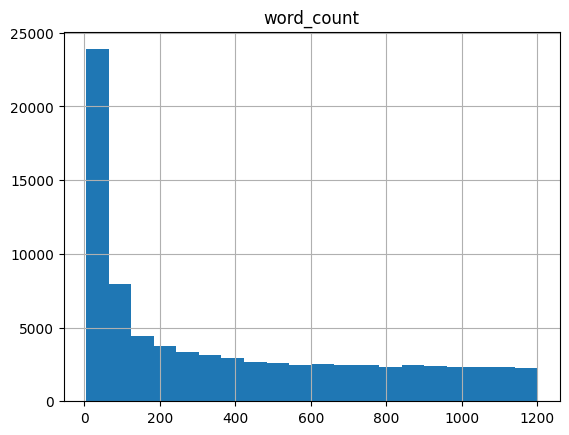

In [60]:
df_filtered.hist(column='word_count', bins=20)

#### Court Types

In [80]:
# Look into the different courts that are present, statistics
court_counts = df_filtered[['id', 'court']].groupby('court').count().sort_values('id', ascending=False)
court_counts.query('id > 500')

,id
court,
"New York Supreme Court, Appellate Division",15396
Supreme Court of the United States,7553
Florida District Court of Appeal,4842
Louisiana Supreme Court,3787
New York Court of Appeals,1898
United States Court of Appeals for the Ninth Circuit,1849
Court of Appeals of Georgia,1448
Supreme Court of Ohio,1438
United States Court of Appeals for the Fifth Circuit,1350


Types of courts seem to include:
- Supreme Court of United States
- United States Court of Appleas (for the ...th Circuit)
- United States Customs Court
- Supreme Court of [State]
- Appellate Court / Court of Appeals / Court of Errors and Appeals
- Superior Court
- New York Supreme Court, General Term; New York Supreme Court, New York Supreme Court, Appllate Division
- Court of Claims
- United States Board of Tax Appeals
- District Court
- Other





In [108]:
def court_type(court):
    court = court.lower()
    if 'supreme court of the united states' in court:
        return 'Supreme Court of the United States'
    if any(['court of appeals' in court, 'appellate court' in court, 'court of errors and appeals' in court] ):
        return 'Court of Appeals'
    if 'supreme' in court:
        return 'State Supreme Court'
    if 'district court' in court:
        return 'District Court'
    if 'superior' in court:
        return 'Superior Court'
    if 'court of claims' in court:
        return 'Court of Claims'
    if 'tax' in court:
        return 'Tax Court'
    if 'customs' in court:
        return 'Customs Court'
    return 'Other'

df_filtered.loc[:, 'court_type'] = df_filtered.loc[:, 'court'].apply(court_type)
df_filtered[['court', 'court_type']]

,court,court_type
8,Alaska Supreme Court,State Supreme Court
9,Alaska Supreme Court,State Supreme Court
10,Alaska Supreme Court,State Supreme Court
13,Alaska Supreme Court,State Supreme Court
22,Alaska Court of Appeals,Court of Appeals
...,...,...
156345,Supreme Court of Wyoming,State Supreme Court
156350,Supreme Court of Wyoming,State Supreme Court
156352,Supreme Court of Wyoming,State Supreme Court
156370,Supreme Court of Wyoming,State Supreme Court


court_type
State Supreme Court                   37651
Court of Appeals                      18455
Supreme Court of the United States     7553
District Court                         7393
Other                                  6483
Superior Court                         1560
Customs Court                          1041
Court of Claims                         520
Tax Court                               228
Name: count, dtype: int64


<Axes: title={'center': 'Court Type Counts'}, ylabel='Frequency'>

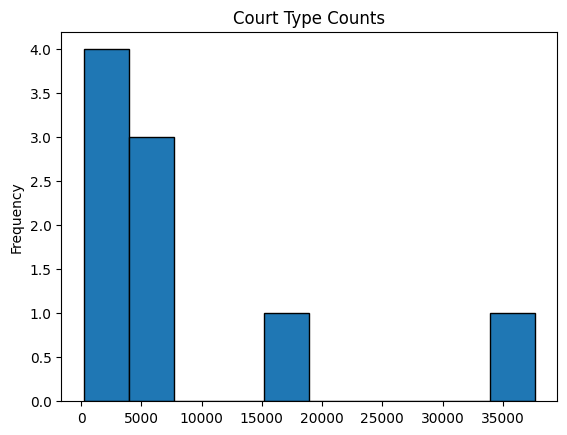

In [118]:
df_courttype_counts = df_filtered.loc[:, 'court_type'].value_counts()
print(df_courttype_counts)
df_courttype_counts.plot.hist(title='Court Type Counts', edgecolor='black')

#### Jurisdictions

In [122]:
# Look into the different jurisdictions that are present, statistics
jurisdiction_counts = df_filtered.loc[:, 'jurisdiction'].value_counts().sort_values(ascending=False)


jurisdiction
Montana                     188
District of Columbia        183
Arizona                     161
Delaware                    145
Utah                        142
New Mexico                  109
Nevada                       98
South Dakota                 88
Idaho                        79
North Dakota                 63
Alaska                       47
Wyoming                      24
Tribal Jurisdictions         18
Navajo Nation                12
Virgin Islands               11
Guam                          8
Northern Mariana Islands      3
Name: count, dtype: int64

<Axes: title={'center': 'Jurisdiction Counts'}, ylabel='Frequency'>

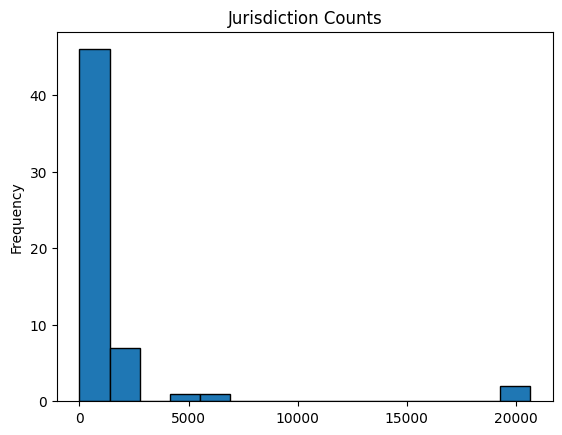

In [117]:
jurisdiction_counts.plot.hist(title='Jurisdiction Counts', bins=15, edgecolor='black')

We are omega unbalanced Jurisdictions. New York is the highest, even ahead of federal. Will definitely need to balance across states.